In [1]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc

# Sample data
X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
y = np.dot(X, np.array([1, 2])) + 3

# Create a linear regression model
model = LinearRegression()

# Fit the model to the data
model.fit(X, y)

# Predict using the model
X_test = np.array([[3, 5], [4, 6]])
y_pred = model.predict(X_test)

print(y_pred)

[16. 19.]


Prendre en compte le nombre de risque pris en compte ? 

Faire varier le niveau de changement de température ? (Par exemple, RCPX.X ? )

Comment prendre en compte l'équité inter-temporelle : taux d'actualisation

Comment prendre en compte la valeur de la vie ? => indice de GINI inter-national

Comment prendre en compte les inégalités sociales ? 

Prise en compte de phénomènes non-monétaires ? 

Quelle est ma question dans cette partie ? 

### Dans l'article de Gillingham : 

Input : 
- population growth
- GDP growth rate
- climate sensitivity

Output: 
- CO2 concentration
- Temperature
- Output (GDP)
- Output log 
- Emissions
- Population
- Radiative Forcings
- Damages
- SCC

=> moi ce qui m'intéresse en output c'est les domages (niveau, répartition, etc.). Et même ce qui m'intéresse c'est quels inputs font varier le plus ces domages. 

Pour ça, il y a plusieurs choses : 

Des variables en input
La forme des fonctions de dommage
Leur niveau de désagrégation (spatiale, par risque)

Ce à quoi il faut que je réflechisse, c'est comment faire des runs qui permettent de refleter ces différents choix. 

In [37]:
ds = xr.open_dataset('results/results_run_2031.nc')
ds

<xarray.Dataset> Size: 725kB
Dimensions:                                                                (
                                                                            A MATRIX YEARS I: 15,
                                                                            AEZ I: 4,
                                                                            AGE ADULTS I: 10,
                                                                            AGE CHAIN I: 16,
                                                                            AGE CHAIN MIDDLE I: 15,
                                                                            ...
                                                                            VINTAGING ANNUAL: 10,
                                                                            bottom: 1,
                                                                            lower: 3,
                                                                            pprofile: 4,
                                                                            upper: 3,
                                                                            time: 27)
Coordinates: (12/254)
  * A MATRIX YEARS I                                                       (A MATRIX YEARS I) <U8 480B ...
  * AEZ I                                                                  (AEZ I) <U13 208B ...
  * AGE ADULTS I                                                           (AGE ADULTS I) <U6 240B ...
  * AGE CHAIN I                                                            (AGE CHAIN I) <U7 448B ...
  * AGE CHAIN MIDDLE I                                                     (AGE CHAIN MIDDLE I) <U6 360B ...
  * AGE CHAIN YOUNG I                                                      (AGE CHAIN YOUNG I) <U6 360B ...
    ...                                                                     ...
  * VINTAGING ANNUAL                                                       (VINTAGING ANNUAL) <U3 120B ...
  * bottom                                                                 (bottom) <U6 24B ...
  * lower                                                                  (lower) <U6 72B ...
  * pprofile                                                               (pprofile) <U9 144B ...
  * upper                                                                  (upper) <U6 72B ...
  * time                                                                   (time) float64 216B ...
Data variables: (12/162)
    define_46_eq_damage_function                                           (time) float64 216B ...
    dice_5_eq_damage_function                                              (time) float64 216B ...
    fund_a1_eq_total_agricultural_impact                                   (time, REGIONS 35 I) float64 8kB ...
    fund_a2_delayed_agricultural_impact_of_the_rate_of_climate_change      (time, REGIONS 35 I) float64 8kB ...
    fund_a2_eq_agricultural_impact_of_the_rate_of_climate_change           (time, REGIONS 35 I) float64 8kB ...
    fund_a2_rate_of_temperature_change                                     (time, REGIONS 35 I) float64 8kB ...
    ...                                                                     ...
    fund_w1_mu_parameter                                                   float64 8B ...
    fund_w1_tau_parameter                                                  float64 8B ...
    fund_extra_initial_revenue                                             (REGIONS 35 I) float64 280B ...
    fund_extra_initial_gdp                                                 (REGIONS 35 I) float64 280B ...
    fund_extra_initial_population                                          (REGIONS 35 I) float64 280B ...
    witness_epsilon                                                        float64 8B ...
Attributes:
    description:   Results for simulation run on Mon Jul  1 01:48:52 2024 usi...
    model_file:    WILIAM_v1.3\WILIAM.py
    timestep:   

In [68]:
variables = pd.read_csv('variables.csv')
variables_interest = variables[variables['isEquation']==True]
variables_interest.head()

,Unnamed: 0,Real Name,Py Name,Subscripts,Units,Limits,Type,Subtype,Comment,Model,Equation,isEquation
3,3,DEFINE: 46: EQ damage function,define_46_eq_damage_function,NaN,NaN,"(nan, nan)",Auxiliary,Normal,NaN,DEFINE,46,True
8,8,DICE: 5: EQ damage function,dice_5_eq_damage_function,NaN,NaN,"(nan, nan)",Auxiliary,Normal,NaN,DICE,5,True
11,11,DICE: 6: EQ abatment function,dice_6_eq_abatment_function,NaN,NaN,"(nan, nan)",Auxiliary,Normal,NaN,DICE,6,True
16,16,DSK: A.128: EQ shock from climate change,dsk_a128_eq_shock_from_climate_change,NaN,NaN,"(nan, nan)",Constant,Normal,TODO,DSK,A.128,True
19,19,FUND: A.1: EQ Total agricultural impact,fund_a1_eq_total_agricultural_impact,['REGIONS 35 I'],NaN,"(nan, nan)",Auxiliary,Normal,NaN,FUND,A.1,True


In [88]:
df_df = pd.read_csv('df_airtable.csv')
df_df['Model'] = df_df['Model - new table'].apply(lambda x: x.split(' ')[0])

variables_interest['Model'] = variables_interest['Model'].str.strip()
variables_interest['Equation'] = variables_interest['Equation'].str.strip()

df_df['Model'] = df_df['Model'].str.strip()
df_df['Equation number'] = df_df['Equation number'].str.strip() 

merged = variables_interest.merge(df_df, left_on=['Model', 'Equation'], right_on=['Model', 'Equation number'], how='left')
merged.head()

C:\Users\gabriel.genelot\AppData\Local\Temp\ipykernel_11992\1402560704.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variables_interest['Model'] = variables_interest['Model'].str.strip()
C:\Users\gabriel.genelot\AppData\Local\Temp\ipykernel_11992\1402560704.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variables_interest['Equation'] = variables_interest['Equation'].str.strip()


,Unnamed: 0,Real Name,Py Name,Subscripts,Units,Limits,Type,Subtype,Comment,Model,...,Equation shape,Formule,Equation form,Zotero reference,IPCC risks,Input categories,Output categories,Latex fragment,Vensim,Vensim name
0,3,DEFINE: 46: EQ damage function,define_46_eq_damage_function,NaN,NaN,"(nan, nan)",Auxiliary,Normal,NaN,DEFINE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8,DICE: 5: EQ damage function,dice_5_eq_damage_function,NaN,NaN,"(nan, nan)",Auxiliary,Normal,NaN,DICE,...,NaN,5.png (https://v5.airtableusercontent.com/v3/u...,Quadratic,[image] ([pdf](zotero://open-pdf/library/items...,NaN,NaN,NaN,\begin{array}{l l}{{\ }}&{{\displaystyle=\psi_...,Oui,NaN
2,11,DICE: 6: EQ abatment function,dice_6_eq_abatment_function,NaN,NaN,"(nan, nan)",Auxiliary,Normal,NaN,DICE,...,NaN,6.png (https://v5.airtableusercontent.com/v3/u...,Quadratic,[image] ([pdf](zotero://open-pdf/library/items...,NaN,NaN,NaN,\begin{array}{l}{{\Lambda({\bf t})\;=\;\theta_...,Oui,NaN
3,16,DSK: A.128: EQ shock from climate change,dsk_a128_eq_shock_from_climate_change,NaN,NaN,"(nan, nan)",Constant,Normal,TODO,DSK,...,NaN,128.png (https://v5.airtableusercontent.com/v3...,NaN,[image] ([pdf](zotero://open-pdf/library/items...,NaN,NaN,NaN,"\text{SHOCKS}~t \sim Beta(\theta_{s1,t}, \thet...",En cours,NaN
4,19,FUND: A.1: EQ Total agricultural impact,fund_a1_eq_total_agricultural_impact,['REGIONS 35 I'],NaN,"(nan, nan)",Auxiliary,Normal,NaN,FUND,...,NaN,a1.png (https://v5.airtableusercontent.com/v3/...,NaN,[image] ([pdf](zotero://open-pdf/library/items...,"Food production reduction,Food security reduction",Production,Production,"A_{t,r}=A_{t,r}^{r}+A_{t,r}^{l}+A_{t,r}^{f}",Oui,FUND total agricultural impact


In [73]:
variables_interest_names = variables_interest['Py Name'].values
variables_interest_names = np.concatenate((variables_interest_names, ['time', 'temperature_change', 'total_population']))


In [77]:
total_damage_equations = ['fund_tot_eq_fund_total_impact', 
                          'witness_dicelike_damage_eq_dicelike_damage',
                          'witness_tipping_point_damage_eq_tipping_point_damge', 
                          'define_46_eq_damage_function', 
                          'dsk_a128_eq_shock_from_climate_change', 
                          'dice_5_eq_damage_function']

In [80]:
df = ds[total_damage_equations].to_dataframe().reset_index()
df.head()

,time,REGIONS 35 I,fund_tot_eq_fund_total_impact,witness_dicelike_damage_eq_dicelike_damage,witness_tipping_point_damage_eq_tipping_point_damge,define_46_eq_damage_function,dsk_a128_eq_shock_from_climate_change,dice_5_eq_damage_function
0,2005.0,AUSTRIA,NaN,0.002476,0.001707,0.002049,0.0,0.002476
1,2005.0,BELGIUM,2.846619e+13,0.002476,0.001707,0.002049,0.0,0.002476
2,2005.0,BULGARIA,3.229255e+08,0.002476,0.001707,0.002049,0.0,0.002476
3,2005.0,CROATIA,2.996817e+08,0.002476,0.001707,0.002049,0.0,0.002476
4,2005.0,CYPRUS,1.631465e+12,0.002476,0.001707,0.002049,0.0,0.002476


In [117]:
df_melted = df.melt(id_vars=['time', 'REGIONS 35 I'], var_name='equation',  value_vars=total_damage_equations, value_name='total_damage')
df_melted

,time,REGIONS 35 I,equation,total_damage
0,2005.0,AUSTRIA,fund_tot_eq_fund_total_impact,NaN
1,2005.0,BELGIUM,fund_tot_eq_fund_total_impact,2.846619e+13
2,2005.0,BULGARIA,fund_tot_eq_fund_total_impact,3.229255e+08
3,2005.0,CROATIA,fund_tot_eq_fund_total_impact,2.996817e+08
4,2005.0,CYPRUS,fund_tot_eq_fund_total_impact,1.631465e+12
...,...,...,...,...
5665,2031.0,INDIA,dice_5_eq_damage_function,7.480851e-03
5666,2031.0,LATAM,dice_5_eq_damage_function,7.480851e-03
5667,2031.0,RUSSIA,dice_5_eq_damage_function,7.480851e-03
5668,2031.0,USMCA,dice_5_eq_damage_function,7.480851e-03


In [118]:
equation_shape = merged[['Py Name', 'Equation form']]
equation_shape

,Py Name,Equation form
0,define_46_eq_damage_function,NaN
1,dice_5_eq_damage_function,Quadratic
2,dice_6_eq_abatment_function,Quadratic
3,dsk_a128_eq_shock_from_climate_change,NaN
4,fund_a1_eq_total_agricultural_impact,NaN
5,fund_a2_eq_agricultural_impact_of_the_rate_of_...,Elasticity
6,fund_a3_eq_agricultural_impact_of_the_level_of...,Quadratic
7,fund_a4_eq_agricultural_imact_of_the_fertilisa...,Logarithmic
8,fund_e1_eq_space_heating,Elasticity
9,fund_e1_eq_space_heating,Elasticity


In [119]:
data = df_melted.merge(equation_shape, left_on='equation', right_on='Py Name', how='left')
data = data.drop(columns=['Py Name'])
data['Equation form'] = data['Equation form'].fillna('Exponential')
data = data.dropna()
data

,time,REGIONS 35 I,equation,total_damage,Equation form
1,2005.0,BELGIUM,fund_tot_eq_fund_total_impact,2.846619e+13,Exponential
2,2005.0,BULGARIA,fund_tot_eq_fund_total_impact,3.229255e+08,Exponential
3,2005.0,CROATIA,fund_tot_eq_fund_total_impact,2.996817e+08,Exponential
4,2005.0,CYPRUS,fund_tot_eq_fund_total_impact,1.631465e+12,Exponential
5,2005.0,CZECH REPUBLIC,fund_tot_eq_fund_total_impact,8.818222e+08,Exponential
...,...,...,...,...,...
5665,2031.0,INDIA,dice_5_eq_damage_function,7.480851e-03,Quadratic
5666,2031.0,LATAM,dice_5_eq_damage_function,7.480851e-03,Quadratic
5667,2031.0,RUSSIA,dice_5_eq_damage_function,7.480851e-03,Quadratic
5668,2031.0,USMCA,dice_5_eq_damage_function,7.480851e-03,Quadratic


In [130]:
drop_columns

Index(['REGIONS 35 I', 'equation', 'time', 'total_damage'], dtype='object')

In [132]:
import statsmodels.api as sm

# Variables à ajouter : 

dummy_variables = ['Equation form']
drop_columns = data.columns.difference(dummy_variables)

df_regression = data.copy()
df_regression = pd.get_dummies(df_regression, columns=dummy_variables, drop_first=True)

y = df_regression['total_damage']
X = df_regression.drop(columns=drop_columns, axis=1)

X = sm.add_constant(X)

X = X.astype(float)
y = y.astype(float)

model = sm.OLS(y, X)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:            total_damage   R-squared:                       0.005
Model:                             OLS   Adj. R-squared:                  0.005
Method:                  Least Squares   F-statistic:                     30.38
Date:              mar., 09 juil. 2024   Prob (F-statistic):           3.72e-08
Time:                         17:07:07   Log-Likelihood:            -1.7928e+05
No. Observations:                 5508   AIC:                         3.586e+05
Df Residuals:                     5506   BIC:                         3.586e+05
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    6.522e+12    4.9e+11     13.306      0.000    5.56e+12    7.48e+12
Equation form_Quadratic -6.522e+12   1.18e+12     -5.511      0.000   -8.84e+12    -4.2e+12
==============================================================================
Omnibus:                     7595.892   Durbin-Watson:                   0.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1248911.820
Skew:                           8.259   Prob(JB):                         0.00
Kurtosis:                      74.896   Cond. No.                         2.74
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Question de recherche : Quels sont les principaux déterminants du niveau de dommage produit par une fonction de dommage (et son corrolaire, à quel point une fonction de dommage est sensible à ces hypothèses)

Donc si je veux faire une régression, la variable expliquée est le niveau de dommage. Ce doit toujours être la même, qui pourrait s'appeler "Dommage" par exemple. 

Les variables explicatives sont : 
- le modèle (FUND, DICE, etc)
- le type de fonction (quadratique, linéaire, etc)
- le nombre d'équation ? 
- le nombre de variables / secteurs couverts ? 
- le niveau d'aggrégation spatiale ? 
- un proxy du taux d'actualisation ? 


Je cherche donc à avoir un tableau de données qui ressemble à ça : 

| Niveau de dommage | Modèle | Type de fonction | Nombre d'équations |
|-------------------|--------|------------------|--------------------|
| 1567522767826      |   FUND     |         Elasticité         |      12              |
| 387974089787                  |    DICE    |     Quadratique             |  1                  |
|                   |        |                  |                    |
|                   |        |                  |                    |

In [100]:
df_regression

,fund_tot_eq_fund_total_impact,time_2006.0,time_2007.0,time_2008.0,time_2009.0,time_2010.0,time_2011.0,time_2012.0,time_2013.0,time_2014.0,...,REGIONS 35 I_LROW,REGIONS 35 I_LUXEMBOURG,REGIONS 35 I_POLAND,REGIONS 35 I_PORTUGAL,REGIONS 35 I_RUSSIA,REGIONS 35 I_SLOVAKIA,REGIONS 35 I_SPAIN,REGIONS 35 I_SWEDEN,REGIONS 35 I_UK,REGIONS 35 I_USMCA
1,2.846619e+13,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3.229255e+08,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2.996817e+08,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1.631465e+12,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,8.818222e+08,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,2.005023e+10,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
941,3.258582e+10,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
942,1.703461e+10,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
943,1.315974e+11,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [99]:
import statsmodels.api as sm

# Create a dataframe with the variables for regression
df_regression = ds['fund_tot_eq_fund_total_impact'].to_dataframe().reset_index()
df_regression = df_regression.dropna()

# Create dummy variables for year and region
df_regression = pd.get_dummies(df_regression, columns=['time', 'REGIONS 35 I'], drop_first=True)

# Separate the dependent variable and independent variables
y = df_regression['fund_tot_eq_fund_total_impact']
X = df_regression.drop('fund_tot_eq_fund_total_impact', axis=1)


# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the regression model

X = X.astype(float)
y = y.astype(float)


model = sm.OLS(y, X)
results = model.fit()

# Print the regression results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     fund_tot_eq_fund_total_impact   R-squared:                       0.964
Model:                                       OLS   Adj. R-squared:                  0.961
Method:                            Least Squares   F-statistic:                     361.9
Date:                        mar., 09 juil. 2024   Prob (F-statistic):               0.00
Time:                                   16:31:27   Log-Likelihood:                -24882.
No. Observations:                            783   AIC:                         4.987e+04
Df Residuals:                                728   BIC:                         5.013e+04
Df Model:                                     54                                         
Covariance Type:                       nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                        2.781e+13    4.2e+12      6.615      0.000    1.96e+13    3.61e+13
time_2006.0                  7.406e+11   4.17e+12      0.178      0.859   -7.44e+12    8.92e+12
time_2007.0                   1.56e+12   4.17e+12      0.374      0.708   -6.62e+12    9.74e+12
time_2008.0                  2.436e+12   4.17e+12      0.585      0.559   -5.74e+12    1.06e+13
time_2009.0                  3.359e+12   4.17e+12      0.806      0.420   -4.82e+12    1.15e+13
time_2010.0                  4.321e+12   4.17e+12      1.037      0.300   -3.86e+12    1.25e+13
time_2011.0                  4.993e+12   4.17e+12      1.199      0.231   -3.18e+12    1.32e+13
time_2012.0                  5.661e+12   4.17e+12      1.359      0.175   -2.52e+12    1.38e+13
time_2013.0                  6.421e+12   4.17e+12      1.541      0.124   -1.76e+12    1.46e+13
time_2014.0                  7.252e+12   4.17e+12      1.741      0.082   -9.27e+11    1.54e+13
time_2015.0                  8.142e+12   4.17e+12      1.955      0.051   -3.63e+10    1.63e+13
time_2016.0                  9.235e+12   4.17e+12      2.217      0.027    1.06e+12    1.74e+13
time_2017.0                  1.009e+13   4.17e+12      2.423      0.016    1.92e+12    1.83e+13
time_2018.0                  1.127e+13   4.17e+12      2.706      0.007    3.09e+12    1.95e+13
time_2019.0                  1.263e+13   4.17e+12      3.033      0.003    4.45e+12    2.08e+13
time_2020.0                  1.398e+13   4.17e+12      3.355      0.001     5.8e+12    2.22e+13
time_2021.0                  1.516e+13   4.17e+12      3.639      0.000    6.98e+12    2.33e+13
time_2022.0                  1.616e+13   4.17e+12      3.880      0.000    7.99e+12    2.43e+13
time_2023.0                  1.696e+13   4.17e+12      4.070      0.000    8.78e+12    2.51e+13
time_2024.0                  1.758e+13   4.17e+12      4.220      0.000     9.4e+12    2.58e+13
time_2025.0                  1.791e+13   4.17e+12      4.300      0.000    9.74e+12    2.61e+13
time_2026.0                  1.811e+13   4.17e+12      4.349      0.000    9.94e+12    2.63e+13
time_2027.0                  1.802e+13   4.17e+12      4.325      0.000    9.84e+12    2.62e+13
time_2028.0                  1.764e+13   4.17e+12      4.235      0.000    9.46e+12    2.58e+13
time_2029.0                  1.721e+13   4.17e+12      4.131      0.000    9.03e+12    2.54e+13
time_2030.0                  1.652e+13   4.17e+12      3.965      0.000    8.34e+12    2.47e+13
time_2031.0                  1.573e+13   4.17e+12      3.776      0.000    7.55e+12    2.39e+13
REGIONS 35 I_BULGARIA       -3.852e+13   4.32e+12     -8.922      0.000    -4.7e+1

In [36]:
data = ds[['fund_tot_eq_fund_total_impact', 'temperature_change', 'total_population', 'gini_gdppc_eu27']].to_dataframe().reset_index()

import seaborn as sns

#sns.lineplot(x='temperature_change', y='fund_tot_eq_fund_total_impact', data=data)
sns.lineplot(x='total_population', y='fund_tot_eq_fund_total_impact', data=data)



KeyError: 'fund_tot_eq_fund_total_impact'

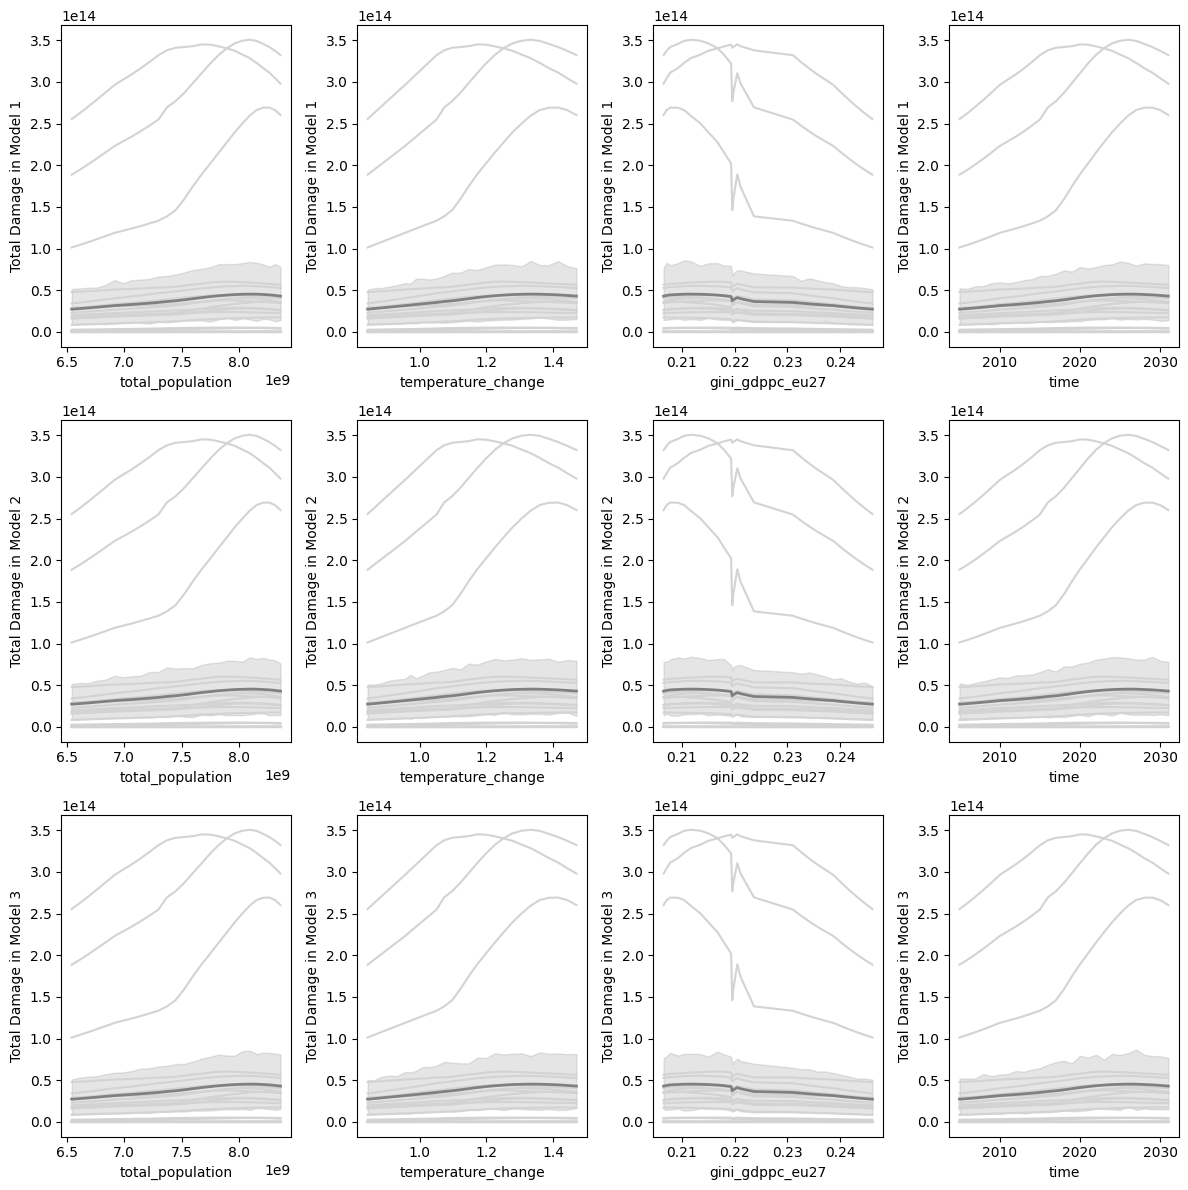

In [43]:
import matplotlib.pyplot as plt

# Define the drivers and models
drivers = ['total_population', 'temperature_change', 'gini_gdppc_eu27', 'time']
models = ['Model 1', 'Model 2', 'Model 3']

# Create the figure and subplots
fig, axs = plt.subplots( len(models), len(drivers), figsize=(12, 12))



# Loop through each subplot

for j, driver in enumerate(drivers):
    for i, model in enumerate(models):
        
        sns.lineplot(x=driver, y='fund_tot_eq_fund_total_impact', data=data, ax=axs[i, j], hue='REGIONS 35 I', palette=['lightgrey']*len(data['REGIONS 35 I'].unique()), legend=False)
        sns.lineplot(x=driver, y='fund_tot_eq_fund_total_impact', data=data, color='grey', linewidth=2, ax=axs[i, j], estimator='mean')

        # Set the title and labels for the current subplot
        #axs[i, j].set_title(f'{driver}')
        axs[i, j].set_xlabel(driver)
        axs[i, j].set_ylabel(f'Total Damage in {model}')

# Adjust the spacing between subplots
plt.tight_layout()
#plt.title('Damage drivers in different models')

# Show the figure
plt.show()